In [9]:
import torch
import numpy as np
from IPython.core.pylabtools import figsize
from PIL import Image
from matplotlib import pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [10]:
class ImageDataSet(TensorDataset):
    def __init__(self, image_dir, transform=None):
        super(ImageDataSet, self).__init__()
        self.main_dir = image_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_loc = os.path.join(self.main_dir, self.image_names[idx])
        image = Image.open(image_loc).convert('RGB')
        if self.transform is not None:
            tenser_img = self.transform(image)
        else:
            raise ValueError("transform is not defined")
        noise_factor = 0.5
        noise_img = tenser_img + noise_factor * torch.randn_like(tenser_img)
        noise_img = torch.clamp(noise_img, 0., 1.)
        return noise_img, tenser_img

In [11]:
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = T.Compose([
    T.Resize((68, 68)),
    T.ToTensor()
])

full_dataset = ImageDataSet(image_dir="../common/dataset/", transform=transform)

print(len(full_dataset))

24853


In [12]:
from torch.utils.data import random_split
train_set, test_set = random_split(full_dataset, [0.75, 0.25])

In [17]:
batch_size = 32
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

In [18]:
test_loader = DataLoader(
    test_set,
    batch_size=batch_size
)

In [19]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 68, 68]) torch.Size([32, 3, 68, 68])


In [47]:
import torch.nn as nn

class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.t_conv1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.conv_out = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.t_conv1(x))
        x = torch.relu(self.t_conv2(x))
        x = torch.relu(self.t_conv3(x))
        x = torch.sigmoid(self.conv_out(x))
        return x

In [48]:
model = ConvDenoiser().to(device)

In [49]:
x = torch.randn(1, 3, 68, 68).to(device)
y = model(x)
print(y.shape)

torch.Size([1, 3, 68, 68])


In [50]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
num_epochs = 10
model.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    for noise_img, tenser_img in train_loader:
        noise_img = noise_img.to(device)
        tenser_img = tenser_img.to(device)
        output = model(noise_img)
        optimizer.zero_grad()
        loss_val = loss(output, tenser_img)
        loss_val.backward()
        optimizer.step()
        train_loss += loss_val.item()
    this_loss = train_loss / len(train_loader)
    print("epoch: {}, loss: {}".format(epoch, this_loss))

epoch: 0, loss: 0.03618372966378569
epoch: 1, loss: 0.013617010430282437
epoch: 2, loss: 0.011436276739508016
epoch: 3, loss: 0.010874233802274843
epoch: 4, loss: 0.01059848128152288
epoch: 5, loss: 0.01042076368748988
epoch: 6, loss: 0.010262889081861862
epoch: 7, loss: 0.010099202035238192
epoch: 8, loss: 0.009934331680875258
epoch: 9, loss: 0.009784227755573607


In [52]:
loader_iter = iter(test_loader)
noise_img, original_imgs = next(loader_iter)
noise_img = noise_img.to(device)
tenser_img = tenser_img.to(device)


In [53]:
model = model.to(device)
noise_img = noise_img.to(device)
outputs = model(noise_img)
print(outputs.shape)

torch.Size([32, 3, 68, 68])


In [54]:
noise_img = noise_img.permute(0, 2, 3, 1).cpu().numpy()
print(noise_img.shape)

(32, 68, 68, 3)


In [55]:
outputs = outputs.permute(0, 2, 3, 1).detach().cpu().numpy()
print(outputs.shape)

(32, 68, 68, 3)


In [56]:
original_imgs = original_imgs.permute(0, 2, 3, 1).detach().cpu().numpy()
print(outputs.shape)

(32, 68, 68, 3)


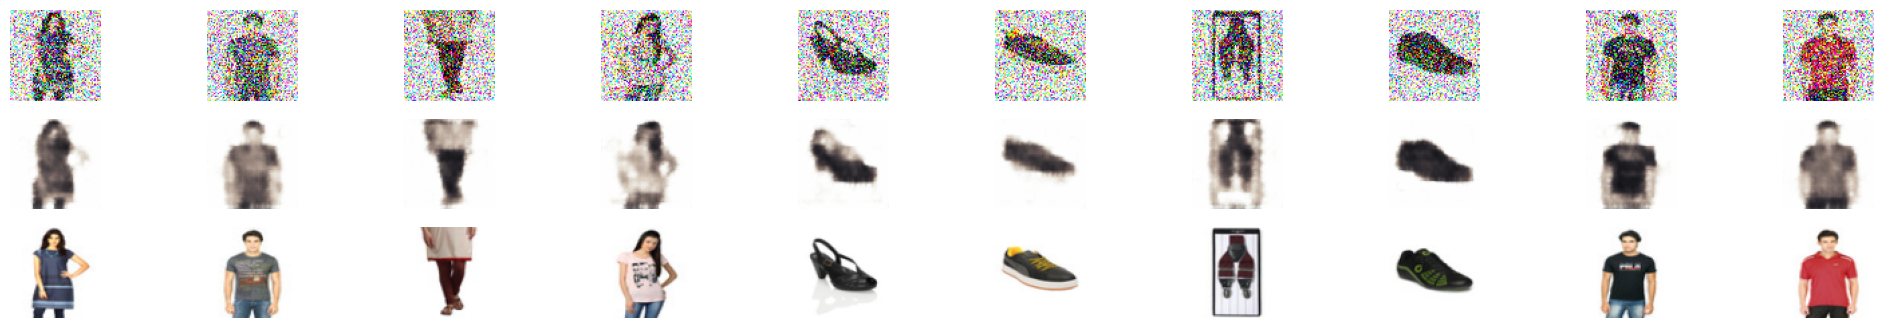

In [57]:
fig, axes = plt.subplots(3, 10, figsize=(25, 4))
for imgs, row in zip([noise_img, outputs, original_imgs], axes):
    for img, ax in zip(imgs, row):
        ax.imshow(img)
        ax.axis('off')
plt.show()